In [1]:
import json
from pathlib import Path
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timezone
from pprint import pprint
from binance import Client
import mt.resources.keys as keys
import statistics as stats

In [119]:
with open(Path("/home/ross/coding/pi_3/modular_trader/continuous/records/trades.json"), 'r') as file:
    trades = json.load(file)
    
trade_df = pl.from_dicts(trades).with_columns(
    pl.col('timestamp').cast(pl.Int64).cast(pl.Datetime(time_zone='UTC', time_unit='ms')),
    pl.col('executed_base_size').cast(pl.Float32),
    pl.col('executed_quote_size').cast(pl.Float32),
    pl.col('executed_quote_size').cast(pl.Float32).alias('avg_trade_size'),
    pl.col('desired_quote_size').mul(pl.col('price_impact')).alias('slippage_cost')
)

trade_df = trade_df.with_columns(
        pl.when(pl.col('action') == 'BUY').then(pl.col('executed_base_size')).otherwise(pl.col('executed_base_size').mul(-1)).alias('directional_base_size'),
        pl.when(pl.col('action') == 'BUY').then(pl.col('executed_quote_size').mul(-1)).otherwise(pl.col('executed_quote_size')).alias('directional_quote_size'),
    )
traded = trade_df['pair'].unique()

In [120]:
client = Client(keys.bPkey, keys.bSkey)
assets = pl.from_dicts(client.get_margin_account()['userAssets']).with_columns(
    pl.col('free').cast(pl.Float32),
    pl.col('locked').cast(pl.Float32),
    pl.col('borrowed').cast(pl.Float32),
    pl.col('interest').cast(pl.Float32),
    pl.col('netAsset').cast(pl.Float32),
).filter(
    # pl.col('netAsset').abs().gt(0),
    # pl.col('asset').is_in(['BNB', 'USDT']).not_(),
    pl.col('asset').is_in([a[:-4] for a in traded]),
)

In [121]:
prices = [float(client.get_ticker(symbol=f"{pair}USDT")['weightedAvgPrice'])
          for pair in assets['asset'].to_list()
          # if pair not in ['BNB', 'USDT']
]
assets = assets.with_columns(pl.Series(prices).alias('price'))
assets = assets.with_columns(pl.col('price').mul(pl.col('netAsset')).alias('usdt_value'))

In [122]:
results = []
for pair, data in trade_df.group_by(['pair']):
    pair = pair[0]
    
    total_volume = data['executed_quote_size'].sum()
    num_trades = len(data)
    
    # data = data.with_columns(
    #     pl.when(pl.col('action') == 'BUY').then(pl.col('executed_base_size')).otherwise(pl.col('executed_base_size').mul(-1)).alias('executed_base_size'),
    #     pl.when(pl.col('action') == 'BUY').then(pl.col('executed_quote_size').mul(-1)).otherwise(pl.col('executed_quote_size')).alias('executed_quote_size'),
    # )
    
    if pair == 'SHIBUSDT':
        print(
            data
            .select(['timestamp', 'action', 'directional_quote_size'])
            .with_columns(
                pl.col('directional_quote_size')
                .cum_sum()
                .alias('cum_sum')
            )
        )
              
    # print(f"pair:{pair}, asset: {pair[:-4]}")
    trades_value = data['directional_quote_size'].sum()
    current_holdings = assets.filter(pl.col('asset') == pair[:-4]).item(0, 'usdt_value')
    if abs(current_holdings) < 10:
        # print(f"trading finished, pnl: {trades_value:.2f} USDT")
        results.append({
            'pair': pair, 
            'total_volume': total_volume, 
            'trades': num_trades, 
            'still_trading': False, 
            'pnl': trades_value, 
            'holdings': current_holdings, 
            'total': trades_value + current_holdings
        })
    else:
        # print(f"{pair} trades don't zero out, unaccounted value: {data['executed_base_size'].sum()}")
        # print(f"still trading, trades value: {trades_value:.2f} USDT, current holding: {current_holdings:.2f} USDT, pnl: {trades_value + current_holdings:.2f} USDT")
        results.append({
            'pair': pair, 
            'total_volume': total_volume, 
            'trades': num_trades, 
            'still_trading': True, 
            'pnl': trades_value, 
            'holdings': current_holdings, 
            'total': trades_value + current_holdings
        })
    # print('')
    
results = pl.from_dicts(results)

shape: (41, 4)
┌─────────────────────────────┬────────┬────────────────────────┬─────────────┐
│ timestamp                   ┆ action ┆ directional_quote_size ┆ cum_sum     │
│ ---                         ┆ ---    ┆ ---                    ┆ ---         │
│ datetime[ms, UTC]           ┆ str    ┆ f64                    ┆ f64         │
╞═════════════════════════════╪════════╪════════════════════════╪═════════════╡
│ 2024-03-29 00:01:03.702 UTC ┆ BUY    ┆ -118.059967            ┆ -118.059967 │
│ 2024-03-29 05:00:59.970 UTC ┆ SELL   ┆ 103.673378             ┆ -14.386589  │
│ 2024-03-29 08:00:59.143 UTC ┆ SELL   ┆ 94.809769              ┆ 80.42318    │
│ 2024-03-29 16:01:04.256 UTC ┆ SELL   ┆ 155.631409             ┆ 236.054588  │
│ 2024-03-30 20:01:02.085 UTC ┆ SELL   ┆ 109.532509             ┆ 345.587097  │
│ …                           ┆ …      ┆ …                      ┆ …           │
│ 2024-04-16 00:01:00.783 UTC ┆ SELL   ┆ 71.564522              ┆ 973.953125  │
│ 2024-04-16 23:01:15.055

In [123]:
results.filter(pl.col('total').gt(100))

pair,total_volume,trades,still_trading,pnl,holdings,total
str,f64,i64,bool,f64,f64,f64
"""OMUSDT""",15727.574219,102,false,3166.53142,0.948535,3167.479954
"""YGGUSDT""",12857.974609,90,false,3130.938257,0.086147,3131.024405
"""PENDLEUSDT""",983.090942,14,false,224.104145,1.076524,225.180669
"""SOLUSDT""",39800.371094,185,false,2969.007027,-0.15942,2968.847606
"""AVAXUSDT""",24383.570312,119,false,140.86607,0.0,140.86607
"""SHIBUSDT""",4748.487793,41,true,1242.72823,21.489204,1264.217434
"""BTCUSDT""",41367.9375,217,false,3247.19461,0.694197,3247.888807
"""NEARUSDT""",14836.498047,108,false,1128.665477,0.0,1128.665477
"""DUSKUSDT""",12283.470703,78,false,2563.174911,0.92693,2564.101842


In [138]:
coin_trades = trade_df.filter(pl.col('pair') == 'BTCUSDT')
coin_trades

timestamp,action,pair,trigger_price,desired_quote_size,executed_base_size,executed_quote_size,avg_price,usdt_fees,price_impact,order_id,logged_by,avg_trade_size,slippage_cost,directional_base_size,directional_quote_size
"datetime[ms, UTC]",str,str,f64,f64,f32,f32,f64,f64,f64,i64,i64,f32,f64,f64,f64
2024-03-18 11:06:52.868 UTC,"""SELL""","""BTCUSDT""",68048.9,1608.675996,0.02364,1608.675781,68048.89,1.207595,0.0,25762721200,1,1608.675781,0.0,-0.02364,1608.675781
2024-03-18 12:00:31.377 UTC,"""SELL""","""BTCUSDT""",68239.98,246.346328,0.00361,246.346329,68239.98,0.185084,0.0,25763723851,1,246.346329,0.0,-0.00361,246.346329
2024-03-18 13:00:31.668 UTC,"""BUY""","""BTCUSDT""",68592.81,114.744844,0.00167,114.550011,68592.82,0.085763,0.0,25765110262,1,114.550011,0.0,0.00167,-114.550011
2024-03-18 14:00:34.551 UTC,"""SELL""","""BTCUSDT""",67578.78,109.477624,0.00162,109.477608,67578.77,0.082111,0.0,25767183727,1,109.477608,0.0,-0.00162,109.477608
2024-03-18 15:00:31.954 UTC,"""SELL""","""BTCUSDT""",66994.89,119.250904,0.00178,119.250908,66994.89,0.089168,0.0,25769428276,1,119.250908,0.0,-0.00178,119.250908
2024-03-18 16:00:33.344 UTC,"""BUY""","""BTCUSDT""",67476.24,57.325019,0.00084,56.680042,67476.24,0.042503,0.0,25771347671,1,56.680042,0.0,0.00084,-56.680042
2024-03-18 17:00:35.170 UTC,"""BUY""","""BTCUSDT""",67061.11,72.328415,0.00107,71.805557,67108.0,0.05372,0.0,25773096422,1,71.805557,0.0,0.00107,-71.805557
2024-03-18 18:00:35.592 UTC,"""BUY""","""BTCUSDT""",67414.75,68.640885,0.00101,68.068649,67394.7,0.051065,0.0,25774989783,1,68.068649,0.0,0.00101,-68.068649
2024-03-18 19:00:31.046 UTC,"""SELL""","""BTCUSDT""",67016.76,62.325587,0.00093,62.325577,67016.75,0.046787,0.0,25776497324,1,62.325577,0.0,-0.00093,62.325577


<AxesSubplot: xlabel='timestamp', ylabel='directional_base_size'>

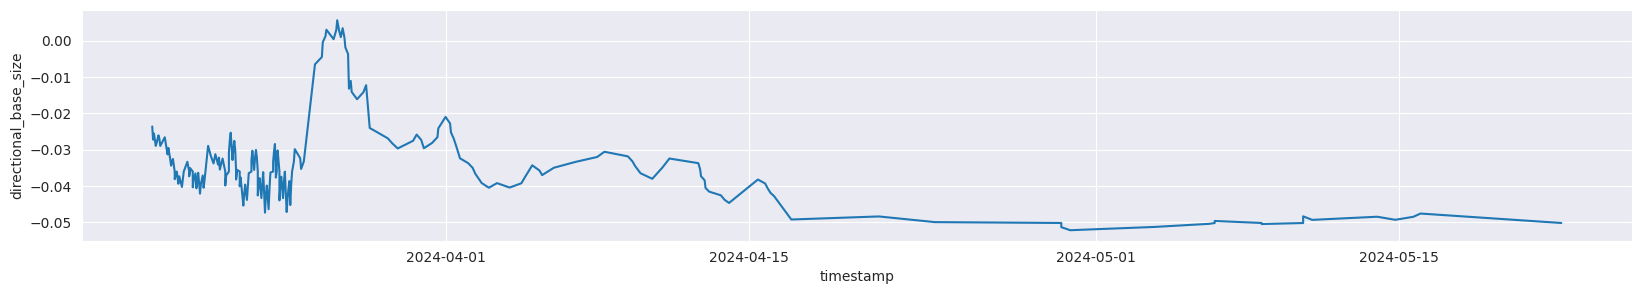

In [139]:
plt.figure(figsize=(20, 3))
sns.lineplot(x=coin_trades['timestamp'], y=coin_trades['directional_base_size'].cum_sum())

<AxesSubplot: xlabel='timestamp', ylabel='directional_quote_size'>

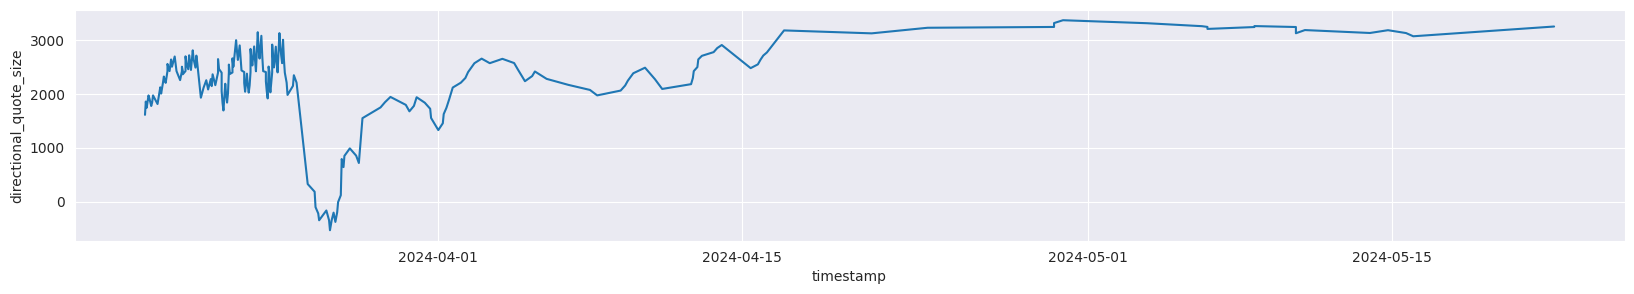

In [140]:
plt.figure(figsize=(20, 3))
sns.lineplot(x=coin_trades['timestamp'], y=coin_trades['directional_quote_size'].cum_sum())

In [142]:
t = client.get_margin_trades(symbol='BTCUSDT')

In [143]:
len(t)

500

In [160]:
downloaded = pl.from_dicts(t).with_columns(
    pl.col('price').cast(pl.Float32),
    pl.col('qty').cast(pl.Float32).alias('executed_base_size'),
    pl.col('quoteQty').cast(pl.Float32).alias('executed_quote_size'),
    pl.col('commission').cast(pl.Float32),
    pl.col('time').cast(pl.Datetime(time_zone='UTC', time_unit='ms')).alias('timestamp')
).drop(['qty', 'quoteQty', 'isMaker', 'isBestMatch', 'isIsolated'])

In [161]:
downloaded

symbol,id,orderId,price,commission,commissionAsset,time,isBuyer,executed_base_size,executed_quote_size,timestamp
str,i64,i64,f32,f32,str,i64,bool,f32,f32,"datetime[ms, UTC]"
"""BTCUSDT""",3175940298,21833866564,29859.150391,0.000037,"""BNB""",1689869292256,true,0.0004,11.94366,2023-07-20 16:08:12.256 UTC
"""BTCUSDT""",3175940299,21833866564,29859.150391,0.000158,"""BNB""",1689869292256,true,0.00171,51.059147,2023-07-20 16:08:12.256 UTC
"""BTCUSDT""",3175970102,21833866623,29661.720703,0.000335,"""BNB""",1689872179056,false,0.00363,107.672043,2023-07-20 16:56:19.056 UTC
"""BTCUSDT""",3176142230,21837422623,29802.160156,0.000334,"""BNB""",1689898345847,true,0.00363,108.181839,2023-07-21 00:12:25.847 UTC
"""BTCUSDT""",3176142234,21837422737,29802.160156,0.000334,"""BNB""",1689898346788,true,0.00363,108.181839,2023-07-21 00:12:26.788 UTC
"""BTCUSDT""",3176295137,21839667709,29783.169922,0.000333,"""BNB""",1689926884761,false,0.00363,108.112907,2023-07-21 08:08:04.761 UTC
"""BTCUSDT""",3176383364,21840717600,29813.169922,0.000331,"""BNB""",1689941345341,true,0.00363,108.221809,2023-07-21 12:09:05.341 UTC
"""BTCUSDT""",3176696560,21845619748,29903.470703,0.000334,"""BNB""",1689984706463,false,0.00363,108.549599,2023-07-22 00:11:46.463 UTC
"""BTCUSDT""",3176762802,21846468215,29900.0,0.000333,"""BNB""",1689998757777,false,0.00363,108.537003,2023-07-22 04:05:57.777 UTC


In [163]:
downloaded.filter(pl.col('time').ge(1709804760000)).with_columns(
    pl.when(pl.col('isBuyer')).then(pl.col('executed_base_size')).otherwise(pl.col('executed_base_size').mul(-1)).cum_sum().alias('base_evolution'),
    pl.when(pl.col('isBuyer')).then(pl.col('executed_quote_size').mul(-1)).otherwise(pl.col('executed_quote_size')).cum_sum().alias('quote_evolution'),
)

symbol,id,orderId,price,commission,commissionAsset,time,isBuyer,executed_base_size,executed_quote_size,timestamp,base_evolution,quote_evolution
str,i64,i64,f32,f32,str,i64,bool,f32,f32,"datetime[ms, UTC]",f64,f64
"""BTCUSDT""",3464339449,25433294103,66801.257812,0.000034,"""BNB""",1709804799651,true,0.00029,19.372366,2024-03-07 09:46:39.651 UTC,0.00029,-19.372366
"""BTCUSDT""",3464504045,25435131945,66734.976562,0.000595,"""BNB""",1709810304274,true,0.00517,345.019836,2024-03-07 11:18:24.274 UTC,0.00546,-364.392202
"""BTCUSDT""",3464597972,25436324290,67031.046875,0.000271,"""BNB""",1709813363938,true,0.00237,158.863586,2024-03-07 12:09:23.938 UTC,0.00783,-523.255789
"""BTCUSDT""",3464603823,25436419927,67077.617188,0.000089,"""BNB""",1709813637796,false,0.00078,52.320545,2024-03-07 12:13:57.796 UTC,0.00705,-470.935244
"""BTCUSDT""",3464654233,25437157386,66629.328125,0.000243,"""BNB""",1709816283583,false,0.00214,142.586761,2024-03-07 12:58:03.583 UTC,0.00491,-328.348482
"""BTCUSDT""",3464665380,25437295040,66732.726562,0.000242,"""BNB""",1709816783158,true,0.00214,142.808044,2024-03-07 13:06:23.158 UTC,0.00705,-471.156527
"""BTCUSDT""",3464743205,25438309714,66941.101562,0.000053,"""BNB""",1709820020678,true,0.00047,31.462317,2024-03-07 14:00:20.678 UTC,0.00752,-502.618843
"""BTCUSDT""",3464796572,25438899657,67233.523438,0.000047,"""BNB""",1709821649366,false,0.00042,28.238079,2024-03-07 14:27:29.366 UTC,0.0071,-474.380764
"""BTCUSDT""",3464876583,25439389820,67734.296875,0.00019,"""BNB""",1709822237000,false,0.00168,113.793625,2024-03-07 14:37:17 UTC,0.00542,-360.587139


In [164]:
all_trades = []
for asset in assets['asset'].to_list():
    all_trades.extend(client.get_margin_trades(symbol=f"{asset}USDT"))
    print(f"{asset} done")
print(f"{len(all_trades) = }")

MATIC done
SHIB done
FRONT done
RAY done
NEAR done
WING done
BTC done
RSR done
AR done
ARB done
GMX done
GNS done
VANRY done
T done
ASR done
BEL done
VTHO done
REI done
ATM done
DUSK done
DOGE done
PEPE done
JASMY done
FLOKI done
NTRN done
OCEAN done
UMA done
ENS done
CKB done
BICO done
YGG done
PEOPLE done
CTXC done
XVG done
GHST done
KMD done
LEVER done
DEXE done
AVAX done
UNFI done
MAV done
FTT done
PHB done
ARKM done
PENDLE done
BLZ done
LPT done
RDNT done
COS done
API3 done
PYR done
ROSE done
GLMR done
SOL done
ETH done
AUCTION done
HIGH done
TRB done
BNX done
TRU done
NULS done
USTC done
CREAM done
FXS done
INJ done
LTO done
BAKE done
LDO done
MAGIC done
OM done
OP done
RNDR done
VIB done
VIC done
SSV done
MOVR done
ARPA done
len(all_trades) = 7869


In [182]:
downloaded = pl.from_dicts(all_trades).with_columns(
    pl.col('price').cast(pl.Float32),
    pl.col('qty').cast(pl.Float32).alias('executed_base_size'),
    pl.col('quoteQty').cast(pl.Float32).alias('executed_quote_size'),
    pl.col('commission').cast(pl.Float32),
    pl.col('time').cast(pl.Datetime(time_zone='UTC', time_unit='ms')).alias('timestamp')
).drop(['qty', 'quoteQty', 'isMaker', 'isBestMatch', 'isIsolated'])

In [183]:
downloaded = downloaded.filter(pl.col('time').ge(1709251200000)).sort('time').with_columns(
    pl.when(pl.col('isBuyer')).then(pl.col('executed_base_size')).otherwise(pl.col('executed_base_size').mul(-1)).cum_sum().alias('base_evolution'),
    pl.when(pl.col('isBuyer')).then(pl.col('executed_quote_size').mul(-1)).otherwise(pl.col('executed_quote_size')).cum_sum().alias('quote_evolution'),
)

In [184]:
downloaded

symbol,id,orderId,price,commission,commissionAsset,time,isBuyer,executed_base_size,executed_quote_size,timestamp,base_evolution,quote_evolution
str,i64,i64,f32,f32,str,i64,bool,f32,f32,"datetime[ms, UTC]",f64,f64
"""BTCUSDT""",3464339449,25433294103,66801.257812,0.000034,"""BNB""",1709804799651,true,0.00029,19.372366,2024-03-07 09:46:39.651 UTC,0.00029,-19.372366
"""BTCUSDT""",3464504045,25435131945,66734.976562,0.000595,"""BNB""",1709810304274,true,0.00517,345.019836,2024-03-07 11:18:24.274 UTC,0.00546,-364.392202
"""SOLUSDT""",482386586,5266724633,138.529999,0.000578,"""BNB""",1709810304560,true,2.42,335.242615,2024-03-07 11:18:24.560 UTC,2.42546,-699.634817
"""NEARUSDT""",154677600,2320689189,5.581,0.000428,"""BNB""",1709810304854,true,44.400002,247.796402,2024-03-07 11:18:24.854 UTC,46.825462,-947.431219
"""ETHUSDT""",1338490838,16417405889,3783.800049,0.000233,"""BNB""",1709810305764,true,0.0358,135.460037,2024-03-07 11:18:25.764 UTC,46.861262,-1082.891256
"""MATICUSDT""",385078737,3582113075,1.1296,0.000117,"""BNB""",1709810306067,true,60.0,67.776001,2024-03-07 11:18:26.067 UTC,106.861262,-1150.667257
"""MATICUSDT""",385078738,3582113075,1.1297,0.000054,"""BNB""",1709810306067,true,27.9,31.518629,2024-03-07 11:18:26.067 UTC,134.761261,-1182.185886
"""AVAXUSDT""",257715666,2812983066,42.66,0.000057,"""BNB""",1709810306357,true,0.78,33.274799,2024-03-07 11:18:26.357 UTC,135.541261,-1215.460686
"""MATICUSDT""",385082731,3582186874,1.1357,0.000009,"""BNB""",1709811105660,true,4.8,5.45136,2024-03-07 11:31:45.660 UTC,140.341261,-1220.912046


<AxesSubplot: xlabel='timestamp', ylabel='quote_evolution'>

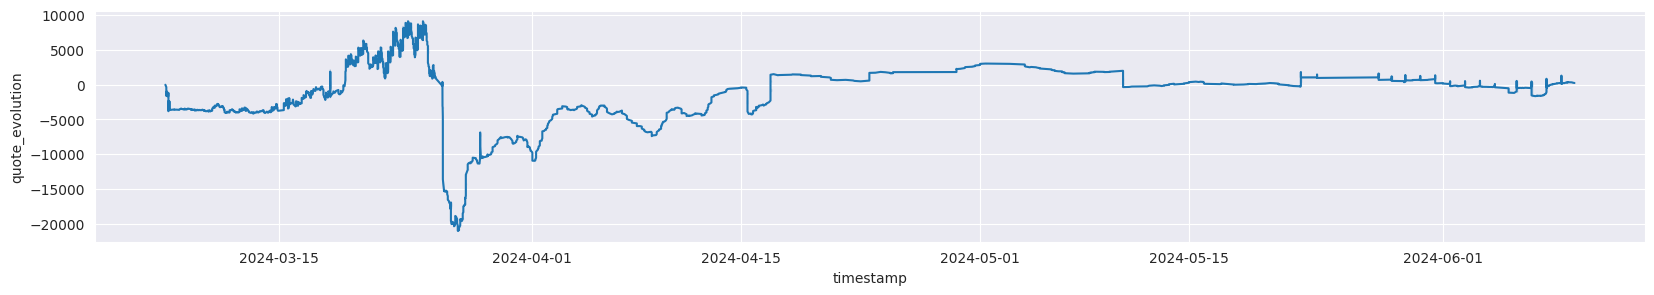

In [202]:
plt.figure(figsize=(20, 3))
sns.lineplot(data=downloaded, x='timestamp', y='quote_evolution')

In [181]:
datetime.fromtimestamp(1709251200000)

datetime.datetime(2024, 3, 1, 0, 0)

In [197]:
transfers = pl.from_dicts(client.get_margin_transfer_history(startTime=1709251200000, endTime=1709253791000)['rows'])

NoDataError: no data, cannot infer schema

In [194]:
transfers.with_columns(
    pl.col('timestamp').cast(pl.Datetime(time_zone='UTC', time_unit='ms')).alias('timestamp')
)

timestamp,asset,amount,type,status,txId,transFrom,transTo
"datetime[ms, UTC]",str,str,str,str,i64,str,str
2024-06-01 23:36:38 UTC,"""USDT""","""9.95680036""","""ROLL_IN""","""CONFIRMED""",176175002814,"""SPOT""","""CROSS_MARGIN"""
2024-06-01 23:32:31 UTC,"""ETH""","""0.003""","""ROLL_IN""","""CONFIRMED""",176174728325,"""SPOT""","""CROSS_MARGIN"""
2024-06-01 23:32:19 UTC,"""AVAX""","""0.52""","""ROLL_IN""","""CONFIRMED""",176174715716,"""SPOT""","""CROSS_MARGIN"""
2024-06-01 23:30:36 UTC,"""USDT""","""40""","""ROLL_OUT""","""CONFIRMED""",176174618148,"""CROSS_MARGIN""","""SPOT"""
